In [2]:
import itertools
from pathlib import Path

import matplotlib.pyplot as plt
import more_itertools
import networkx as nx
import numpy as np


import d3networkx as d3nx
from d3networkx.d3graph import D3DiGraph

In [10]:
# d3 = await d3nx.create_d3nx_visualizer(
#     interactive=False,
#     node_dstyle=d3nx.node_style(size=5, fill="#FFFFFF", stroke="#494949"),
#     edge_dstyle=d3nx.edge_style(stroke_width=1.25),
#     event_delay=0,
#     canvas_size=(1000, 800)
# )

websocket server started...

networkx connected...

In [4]:
G = D3DiGraph(nx.read_gml("data/dart_stops.gml"))
# Unpack node pos from list to numpy array
nx.set_node_attributes(
    G,
    {node: np.array(pos) for node, pos in nx.get_node_attributes(G, "pos").items()},
    "pos",
)
# G = D3DiGraph(nx.path_graph(5, create_using=nx.DiGraph))

# d3.clear()
# d3.set_graph(G)
# d3.update
# d3.set_interactive(True)

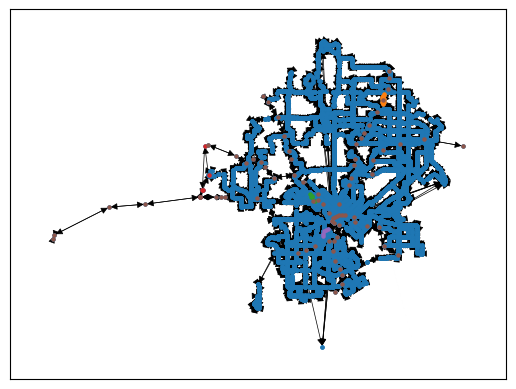

In [29]:
pos = nx.get_node_attributes(G, "pos")

comps = list(nx.weakly_connected_components(G))

# Plot each weakly-connected component in its own color
nx.draw_networkx(G, pos=pos, node_size=5, width=0.5, with_labels=False)
colors = plt.get_cmap('tab10').colors # type: ignore

for component, color in zip(comps, colors):
    nx.draw_networkx(
        G.subgraph(component),
        pos=pos,
        node_color=[color],
        node_size=5,
        width=0.5,
        with_labels=False,
    )

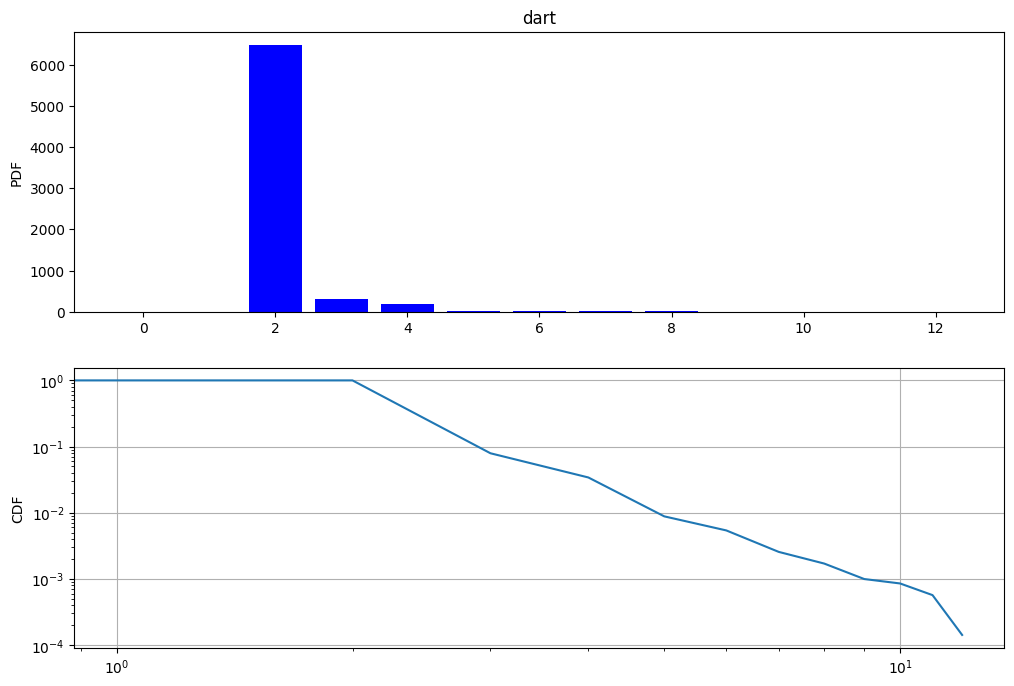

In [23]:
from powerlaw import calc_powerlaw_multi

calc_powerlaw_multi({"dart": G})
plt.show()

In [21]:
# Reload powerlaw (if necessary)
# del calc_powerlaw_multi
# import powerlaw
# import importlib
# importlib.reload(powerlaw)

<module 'powerlaw' from 'c:\\Users\\Andrew\\Code\\dcns-project\\powerlaw.py'>